#  Определение закономерностей успешных компьютерных игр

В нашем распоряжении данные интернет-магазина «Стримчик» — архив данных о продажах игр, оценки пользователей и экспертов, жанры и платформы за несколько лет. 

**Цель исследования** - определить закономерность определяющую успешность игр и установить параметры, влияющие на эту закономерность. Это позволит  сделать ставку на потенциально популярный продукт и планировать рекламные кампании. 

**Задачи исследования** - для выполнения поставленной цели мы проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки мы поищем возможность исправить самые критичные ошибки данных. Далее мы определим актуальный период и проанализируем параметры, которые могут влиять на успешность той или иной игровой платформы или компьютерной игры. Также, нам нужно будет составить потрет пользователя каждого региона и проверить следующие гипотезы:

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**Исходные данные:** данные о продаже игр мы получили из файла `/datasets/games.csv`. В датасете доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр.

Таким образом, исследование пройдёт в четыре этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Анализ и описание данных.
 4. Проверка гипотез.

## Изучение общей информации

Составим первое представление о данных. Импортируем библиотеку pandas и остальные библиотеки для проведения анализа, сохраним файлы в переменные `df` и выведем первые 5 строк таблицы методом `.head`

In [46]:
import warnings
warnings.filterwarnings('ignore')# отключим всплывающие предупреждения

In [47]:
import pandas as pd
import math 
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np #импортируем библиотеку numpy
from math import ceil


In [48]:
df = pd.read_csv('games.csv')
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


На первый взгляд заметны некоторые недочеты в данных,а именно:
1. Названия колонок имеют разный регистр.
2. В столбцах "	Critic_Score", "User_Score" и "Rating" встречаются пропуски.
3. В стоолбце "Year_of_release" тип данных `float`, что противоречит логике.

Одной командой получим общую информацию о таблице:

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Итак, в таблице 11 столбцов, имеющих разный тип данных: `float` и `object`.

Согласно документации к данным:

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB.

Данные за 2016 год могут быть неполными.

**Вывод**

В каждой строке таблицы — данные о продажах игр, оценки пользователей и экспертов, жанры и платформы за несколько лет.

Предварительно можно утверждать, что, данных достаточно для анализа и проверки гипотез. Но в данных встречаются пропуски, неверные типы данных и разные ригистры в наименованиях столбцов. 

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Обработка пропусков

Прежде чем обрабатывать пропуски, приведем к нижнему регистру все наименования столбцов с помощью метода `.str.lower()`.

In [50]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Выявим в каких колонках есть пропущенные значения методом .isna()

In [51]:
print(df.isna().sum())

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64


Мы заметили, что в колонках "name" и "year_of_release" есть пропущенные значения. Очевидно, что количество данных пропусков очень мало чтобы исказить данные, поэтому можем удалить эти пропуски..

In [52]:
df = df.dropna(subset=['name'])#удалим пропуски из столбца "name"

missed_values = df['year_of_release'].isna().sum()/df.shape[0]
print('В столбце "year_of_release" пропущено всего {:.0%}'.format(missed_values), 'от общего количества строк.') 
print('Пропуски в столбце "year_of_release" до:', df['year_of_release'].isna().sum())
df = df.dropna(subset=['year_of_release'])#удалим пропуски из столбца "year_of_release"
print('Пропуски в столбце "year_of_release" до:', df['year_of_release'].isna().sum())


В столбце "year_of_release" пропущено всего 2% от общего количества строк.
Пропуски в столбце "year_of_release" до: 269
Пропуски в столбце "year_of_release" до: 0


Также мы заметили что в столбцах "user_score" и "critic_score" имеются пропуски. Заменять пропуски в этих данных неуместно,т.к. любое заполнение исказит результаты корреляционного анализа и стат-тестов.
Однако, мы можем заменить пропуски в столбце "rating" на `tbd` , т.к. он является категориальной переменной.

In [53]:
df['rating']=df['rating'].fillna('tbd')

В документации указано, что в столбце с оценкой пользователей есть  аббревиатура 'tbd'. Это расшифровка "to be determined" или "to be discussed", что значит "будет определено". Для дальнейшего анализа нам необходимо избавиться от этой аббревиатуры и заменить ее на пропуск.

In [54]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('nan')

После данной операции количество прпопусков с столбце "user_score" должно увеличиться.

In [55]:
print(df.isna().sum())

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64


### Замена типа данных

Выведем еще раз общую информацию о таблице:

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Мы видим, что данные в колонке "year_of_release" имеют тип `float64`, что не совсем корректно для года выпуска. Заменим эти данные на тип `int` с помощью `.astype()`.

In [57]:
df['year_of_release'] = df['year_of_release'].astype(int)#заменим тип данных
df['year_of_release'].dtype#проверим тип данных
print('Тип данных в столбце "year_of_release"-', df['year_of_release'].dtype)

Тип данных в столбце "year_of_release"- int32


Также, мы заметили что тип данных в в столбцах "user_score" и "critic_score" - `object`, произведем замену типа данных с помощью `to_numeric()`.

In [58]:
df['user_score'] = df['user_score'].apply(pd.to_numeric, errors='ignore')
df['critic_score'] = df['critic_score'].apply(pd.to_numeric, errors='ignore')

Итак, у нас почти все готово для анализа, однако для полной картины нам не хватает суммарных продаж по всем регионам - для этого создадим отдельный столбец.

In [59]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [60]:
df.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,tbd,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,tbd,31.38


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB


**Вывод**

При заполнении пропусков мы обнаружили 2 проблемы в данных:

- не подходящие для анализа типы данных, 
- пропущенные значения в столбцах.

Мы исправили некорректные значения и заполнили пропуски, где это было логично, а также заменили типы данных.

### Рейтинг ESRB

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков». 

«EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет.\
«E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет.Первоначально "K-A" ("Kids to Adults").\
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше».\
«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.\
«M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. \
«AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. \
«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.\

Приведем значения столбца "raitng" в более привычный вид при помощи функции и категоризации данных.

In [62]:
def rating(item):
    """
    Возвращает расшифровку rating используя правила
    - '3+', если raiting = EC;
    - '6+', если raiting = E;
    - '10+', если raiting = E10+;
    - '13+', если raiting = T;
    - '17+', если raiting = M;
    - '18+', если raiting = AO;
    - 'unknown', если raiting = RP или tbd.
    """
    if item =='EC': return '3+'
    if item =='E': return '6+'
    if item =='E10+': return '10+'
    if item =='T': return '13+'
    if item =='M': return '17+'
    if item =='AO': return '18+'
    if item =='K-A': return '6+'
    
    return 'unknown'

df['rating_desc'] = df['rating'].apply(rating)
print(df['rating_desc'].drop_duplicates())   
    

0            6+
1       unknown
16          17+
39          13+
61          10+
875         18+
4297         3+
Name: rating_desc, dtype: object


## Исследовательский анализ данных

### Исследовании динамики продаж по годам

Проведем анализ выпуска игр по годам, для это построим гистограмму.

Text(0.5, 1.0, 'Динамика выпуска компьютерных игр за 1980-2016 гг., млн. шт.')

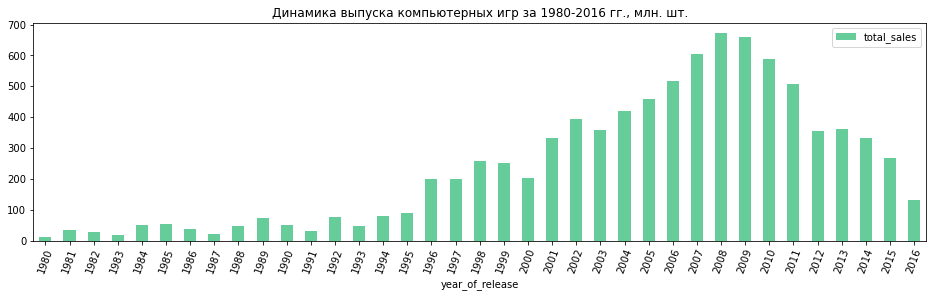

In [63]:
myhex = '#66CC99' #параметр задающий  цвет
df.groupby('year_of_release').agg({'total_sales':'sum'}).plot(kind='bar', rot=70,figsize=(16,4), color = myhex);
plt.title('Динамика выпуска компьютерных игр за 1980-2016 гг., млн. шт.')

Исходя из полученной гистограммы мы видим, что до 1995 г. количество выпущенных игр оставалось примерно на одном уровне, далее начинается  рост с резкими скачками в 1996 и 2001 году. Затем продажи достигают своего пика в 2008 и 2009 годах, а после мы наблюдаем снижение количества проданных копий. В целом можно утверждать, что после 2011 года рынок компьютерных игр находится в стадии стагнации.
Проведем анализ продаж по платформам. Для начала определим платформы с наибольшими суммарными продажами.

### Исследовании динамики продаж по игровым платформам

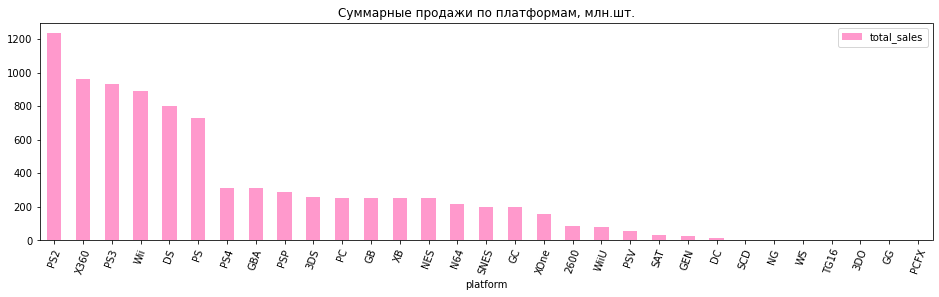

In [64]:
myhex = '#FF99CC' #параметр задающий  цвет

df.groupby('platform').agg({'total_sales':'sum'}).sort_values(by = 'total_sales', ascending = False).plot(kind='bar', rot=70,figsize=(16,4), color = myhex);

plt.title('Суммарные продажи по платформам, млн.шт.');

Благодаря построенной гистограмме, мы можем определить что у нас есть явный лидер - PS2 и пятерка последующих платформ, которые делят между собой основную часть рынка. Построим распределение по годам для каждой платформы на графике из первой десятки лидеров.

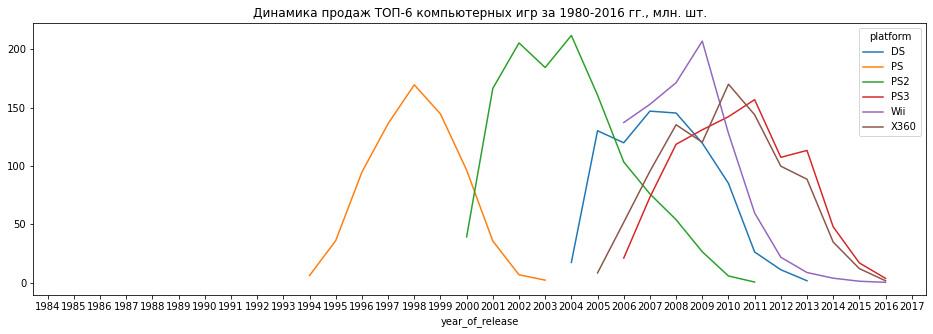

In [65]:
top_6 = (df
         .groupby('platform')
         .agg({'total_sales':'sum'})
         .sort_values(by = 'total_sales', ascending = False)
         .head(6).index
        )
ax = (df
      .query('platform in @top_6')
      .pivot_table(index = 'year_of_release',
                   columns = 'platform',
                   values = 'total_sales', 
                   aggfunc = 'sum')
      .plot(figsize = (16,5))
     );
#  Устанавливаем интервал основных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Динамика продаж ТОП-6 компьютерных игр за 1980-2016 гг., млн. шт.');

Судя по полученной динамике, мы можем определить, что в среднем платформы живут около 10 лет. Объем рынка не меняется, не смотря на то, что у каждой платформы резкий рост сменяется резким падением, т.к. каждая последующая платформа забирает значительную долю рынка у предыдущей. Это происходит в среднем в течение 3х лет. Т.е. каждая платформа выходит на свой пик продаж в среднем через 3 года. 

### Определение актуального периода для исследования

Поскольку нам нужно спрогнозировать продажи на 2017 год, мы будем использовать данные за последние 3 года, с 2013 по 2016 включительно.
Сформируем новый датасет и построим график продаж.

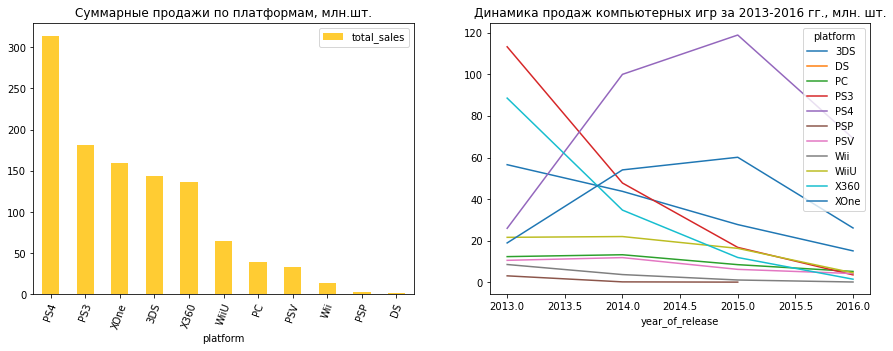

In [66]:
df_act = df.query('2016 >= year_of_release >= 2013') #формируем новый датасет с данными за 2013-2016 гг.

fig, axes = plt.subplots(1,2, figsize=(15,5)) #параметр, располагающий 2 графика в одной плоскости

myhex = '#FFCC33' #параметр задающий  цвет
(df_act
 .groupby('platform')
 .agg({'total_sales':'sum'})
 .sort_values(by = 'total_sales',ascending = False)
 .plot(kind='bar', rot=70,
       color = myhex, ax=axes[0])
);

axes[0].set_title('Суммарные продажи по платформам, млн.шт.')

(df_act
 .pivot_table(index = 'year_of_release', 
              columns = 'platform',
              values = 'total_sales',
              aggfunc = 'sum')
 .plot(ax=axes[1])
);
axes[1].set_title('Динамика продаж компьютерных игр за 2013-2016 гг., млн. шт.');


Исходя из полученных графиков мы видим, что за последние годы произошла смена лидера рынка с PS2 на PS4. В то же время PS3 опередила по продажам X360, однако обе платформы находятся в стадии спада. В целом, т.к. данные за 2016 г. неполные мы не видим положительной динамики ни у одной из платформ. Однако, хорошо заметно что по итогам 2014 года PS4 и XOne находились в стадии роста. Также, наименее отрицательный рост имеет платформа 3DS. Таким образом, мы имеем три потенциально прибыльные платформы.
Для того, чтобы в этом убедиться построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

### Анализ редких и выбивающихся значений

In [67]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

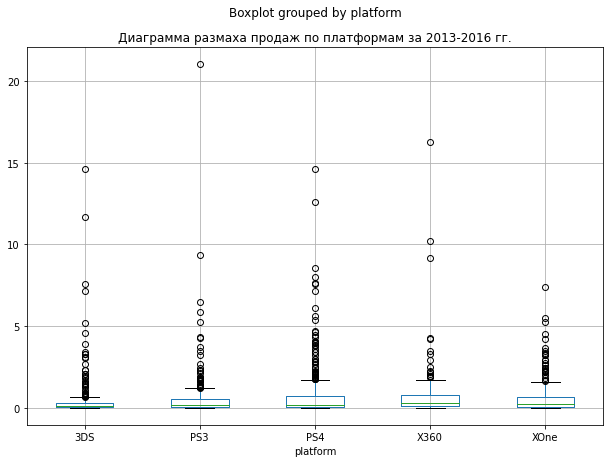

In [68]:
top_platform_names = ['PS4', 'PS3', 'XOne', '3DS', 'X360']
top_5_platforms = df_act[df_act['platform'].isin(top_platform_names)]
top_5_platforms.boxplot(by='platform', column ='total_sales', figsize=(10,7));#построение диаграммы размаха по платформам
plt.title('Диаграмма размаха продаж по платформам за 2013-2016 гг.');

Первое на что бросается взгляд - выбросы. Очевидно, что у каждой платформы есть свои топ-селлеры, которые тянут за собой значительную часть продаж. Так мы видим, что явный лидер есть у PS3 и XOne, в то время как у остальных платформ по 2-3 топ селлера. Взгляним на "диаграммы - ящики" поближе.  

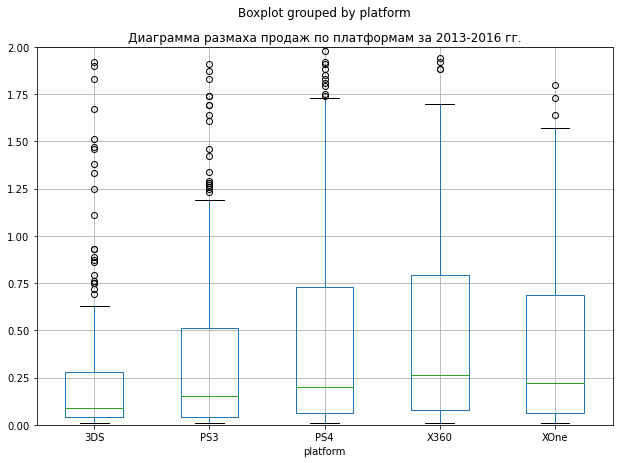

In [69]:
top_5_platforms.boxplot(by='platform', column ='total_sales', figsize=(10,7));#построение диаграммы размаха по платформам
plt.ylim(0,2)
plt.title('Диаграмма размаха продаж по платформам за 2013-2016 гг.');

Исходя из полученной диаграммы мы видим, что самая высокая медиана у платформ X360 и XOne, что говорит о том, что распределение выручки игр на данной платформе относительно равномерно распределено и имеет не так много выбросов как остальные платформы. Ведь несмотря на наивысшую медиану в продажах, платформа X360 занимает пятое место по количеству проданных копий. 
Посмотрим, как влияют на продажи внутри живых платформ отзывы пользователей и критиков.

### Исследование факторов, влияющих на величину продаж

Чтобы понять что имеет наибольшее влияние на продажи игр используем коэффициент корреляции Пирсона. Также построим диаграммы рассеяния для наглядности.

In [70]:
#создадим функциб для расчета корреляции для каждой платформы
def correlation(df):
    user_score_corr = df['user_score'].corr(df['total_sales']) #вычисление первого коэффициента
    critic_score_corr = df['critic_score'].corr(df['total_sales'])#вычисление второго коэффициента
    platform_name = df['platform'].unique() #получим название платформы, для которой проводится расчет
    print('Влияние оценки пользователей', platform_name,'. Коэффициент корреляции равен {:.0%}'.format(user_score_corr))
    print('Влияние оценки критиков',platform_name, '. Коэффициент корреляции равен {:.0%}'.format(critic_score_corr)) 

correlation(df_act.query('platform == "PS4"')) #применим функцию

Влияние оценки пользователей ['PS4'] . Коэффициент корреляции равен -3%
Влияние оценки критиков ['PS4'] . Коэффициент корреляции равен 41%


Влияние оценки пользователей ['PS4'] . Коэффициент корреляции равен -3%
Влияние оценки пользователей ['XOne'] . Коэффициент корреляции равен -7%
Влияние оценки пользователей ['3DS'] . Коэффициент корреляции равен 24%


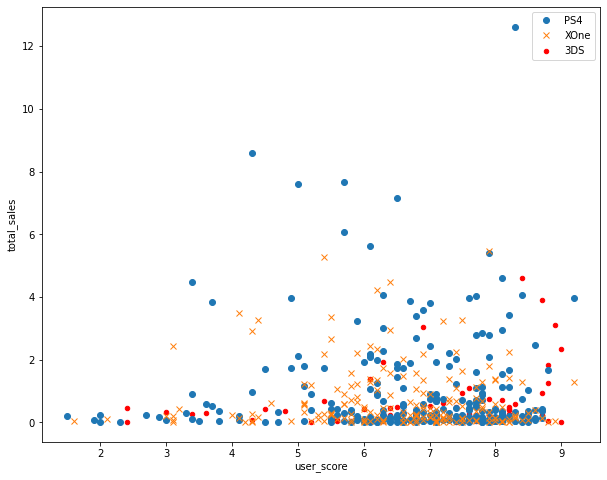

In [71]:
ax = df_act.query('platform == "PS4"').plot(x = 'user_score', y = 'total_sales', style = 'o', label = 'PS4', figsize=(10,8))
df_act.query('platform == "XOne"').plot(x = 'user_score', y = 'total_sales', style = 'x', ax=ax, label = 'XOne')
df_act.query('platform == "3DS"').plot(kind = 'scatter', x = 'user_score', y = 'total_sales', style = 'x', color = 'red',
                                       ax=ax, label = '3DS')
plt.legend();

#создадим функцию для расчета корреляции оценки пользователей для каждой платформы
def correlation_user(df):
    user_score_corr = df['user_score'].corr(df['total_sales']) #вычисление коэффициента корреляции
    platform_name = df['platform'].unique() #получим название платформы, для которой проводится расчет
    print('Влияние оценки пользователей', platform_name,'. Коэффициент корреляции равен {:.0%}'.format(user_score_corr))
    
correlation_user(df_act.query('platform == "PS4"')) #применим функцию
correlation_user(df_act.query('platform == "XOne"'))
correlation_user(df_act.query('platform == "3DS"'))


Как мы видим по графику, оценка пользователей практически не влияет на количество проданных копий. Об этом же говорят и коэффициенты корреляции менее 0,3 - связи практически нет. Проверим влияние оценки критиков на продажи.

Влияние оценки критиков ['PS4'] . Коэффициент корреляции равен 41%
Влияние оценки критиков ['XOne'] . Коэффициент корреляции равен 42%
Влияние оценки критиков ['3DS'] . Коэффициент корреляции равен 36%


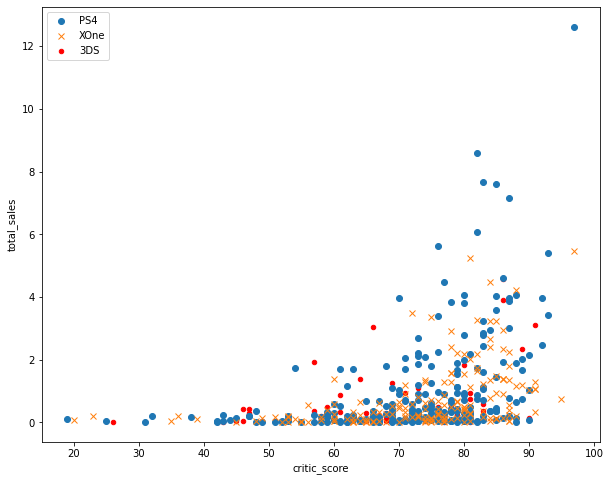

In [72]:
ax = df_act.query('platform == "PS4"').plot(x = 'critic_score', y = 'total_sales', style = 'o', label = 'PS4', figsize=(10,8))
df_act.query('platform == "XOne"').plot(x = 'critic_score', y = 'total_sales', style = 'x', ax=ax, label = 'XOne')
df_act.query('platform == "3DS"').plot(kind = 'scatter', x = 'critic_score', y = 'total_sales', style = 'x', color = 'red',
                                       ax=ax, label = '3DS')
plt.legend();

#создадим функцию для расчета корреляции оценки критиков для каждой платформы
def correlation_critic(df):
    critic_score_corr = df['critic_score'].corr(df['total_sales']) #вычисление коэффициента корреляции
    platform_name = df['platform'].unique() #получим название платформы, для которой проводится расчет
    print('Влияние оценки критиков',platform_name, '. Коэффициент корреляции равен {:.0%}'.format(critic_score_corr)) 
    
correlation_critic(df_act.query('platform == "PS4"')) #применим функцию
correlation_critic(df_act.query('platform == "XOne"'))
correlation_critic(df_act.query('platform == "3DS"'))

Диаграмма рессеяния показывает, что в некоторых случаях высокая оценка критиков увеличивает число продаваемых игр. Но нельзя в целом утверждать, что оценка критиков влияет на продажи игр, т.к. коэффициенты корреляции менее 0,5 - это говорит о слабой связи между продажами и оценками критиков. Тем не менее влияние оценки пользователей на продажи игр еще меньше.  

Интересно, повторяется ли определенная тенденция для других популярных платформ? Повторим процедуру для оставшихся "PS3" и "X360'. 

In [73]:
def correlation(df):
    user_score_corr = df['user_score'].corr(df['total_sales']) #вычисление первого коэффициента
    critic_score_corr = df['critic_score'].corr(df['total_sales'])#вычисление второго коэффициента
    platform_name = df['platform'].unique() #получим название платформы, для которой проводится расчет
    print('Влияние оценки пользователей', platform_name,
          '. Коэффициент корреляции равен {:.0%}'
          .format(user_score_corr))
    print('Влияние оценки критиков', platform_name, 
          '. Коэффициент корреляции равен {:.0%}'
          .format(critic_score_corr)) 
    
correlation(df_act.query('platform == "PS3"'))
correlation(df_act.query('platform == "X360"'))

Влияние оценки пользователей ['PS3'] . Коэффициент корреляции равен 0%
Влияние оценки критиков ['PS3'] . Коэффициент корреляции равен 33%
Влияние оценки пользователей ['X360'] . Коэффициент корреляции равен -1%
Влияние оценки критиков ['X360'] . Коэффициент корреляции равен 35%


Исходя из полученных графиков становится понятным, что на всех популярных платформах ни оценки пользователей, ни оценки критиков не влияют на количество проданных копий.

### Исследование распределения игр по жанрам

Мы определили, что оценки не влияют на количество проданных копий, поэтому посмотрим на распределение игр по жанрам.

In [74]:
df_act.loc[~df_act['genre'].isin(['Action', 'Shooter', 'Sports', 'Role-Playing']), 'genre'] = 'Others'
df_act['genre'].unique()

array(['Action', 'Shooter', 'Role-Playing', 'Others', 'Sports'],
      dtype=object)

Text(0.5, 1.0, 'Суммарные продажи по жанрам, млн.шт.')

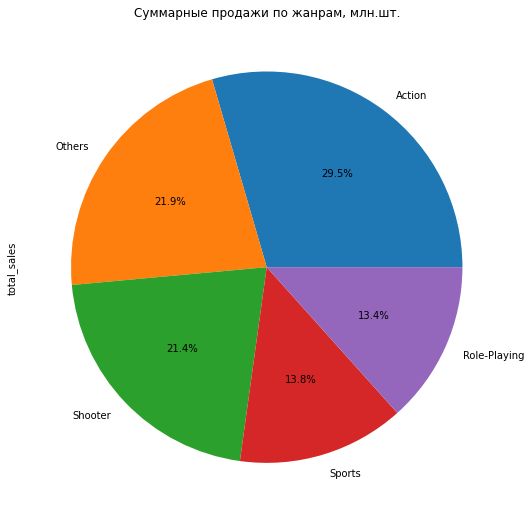

In [75]:
df_act.groupby('genre').agg({'total_sales':'sum'}).sort_values(by = 'total_sales', 
                                                                  ascending = False).plot(kind='pie', rot=70,figsize=(9,9), 
                                                                                          subplots=True, legend=False, autopct='%1.1f%%');

plt.title('Суммарные продажи по жанрам, млн.шт.')

Итак, судя по полученной диаграмме, мы видим, что самым объемообразающим жанром являяется "Action", затем на втором месте жанр "Shooter" и третье место делят между собой "Sports" и "Role-Playing". В то же время мы видим что жанры "Puzzle" и "Strategy" пользуются наименьшей популярностью в последние годы. Взглянем на медианный доход кадого жанра. 

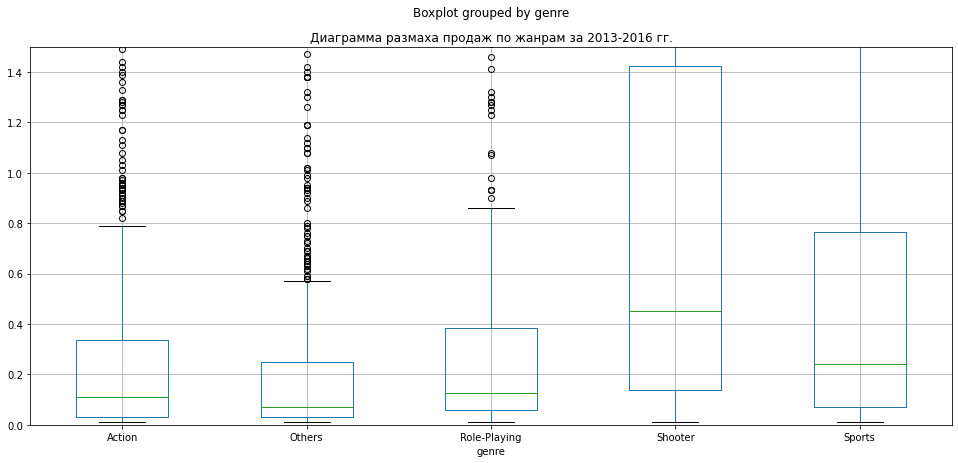

In [76]:
df_act.boxplot(by='genre', column ='total_sales', figsize=(16,7));#построение диаграммы размаха по платформам
plt.ylim(0,1.5)
plt.title('Диаграмма размаха продаж по жанрам за 2013-2016 гг.');

Таким образом мы можем определить, что самый высокий медианный доход у жанра "Shooter", затем идут жанры "Sports" и "Platform", в то время как последний не входит в первую пятерку по суммарным продажам. Это вновь говорит о том, что самые популярные жанры получают свое лидерство засчет определенных игр, которые приносят наибольшую часть прибыли. Так, мы видим, что у жанра "Action" весьма средний мединный доход, а значит он находится в лидерах только из-за пары очень популярных игр. Выведем их на экран.

In [77]:
df_act.sort_values(by='total_sales',ascending=False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,rating_desc
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,17+
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27,17+
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,tbd,14.63,unknown
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,tbd,14.60,unknown
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,17+
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,tbd,11.68,unknown
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24,17+
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36,17+
72,Minecraft,X360,2013,Others,5.70,2.65,0.02,0.81,NaN,NaN,tbd,9.18,unknown
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,6+


**Вывод**

Мы определили пик продаж на рынке компьютерных игр и выделили акутальный период для анализа. Затем проанализировали срок жизни игровых платформ и выделили нетолько самые популярные, но и самые живые платформы. Также мы проанализировли распределение игр по жанрам и определили тенденцию глобального рынка компьютерных игр в целом. Однако, нужно проанализировать каждый регион по отдельности на предмет отличий и особенностей пользователя.  

## Портрет пользователя каждого региона

Для того, чтобы составить портрет пользователя каждого региона, необходимо определить для пользователя каждого региона: самые популярные платформы, самые популярные жанры и влияние рейтинга ESRB на продажи в отдельном регионе. Для этого будем использовать циклы и построим накопительную столбчатую гистограмму.

,na_sales,eu_sales,jp_sales
platform,,,
3DS,38.20,30.96,67.81
PS3,63.50,67.81,23.35
PS4,108.74,141.09,15.96
X360,81.66,42.52,0.51
XOne,93.12,51.59,0.34


,na_sales,eu_sales,jp_sales
platform,,,
3DS,0.099164,0.092703,0.628045
PS3,0.164841,0.203042,0.216264
PS4,0.282280,0.422463,0.147819
X360,0.211983,0.127317,0.004724
XOne,0.241732,0.154475,0.003149


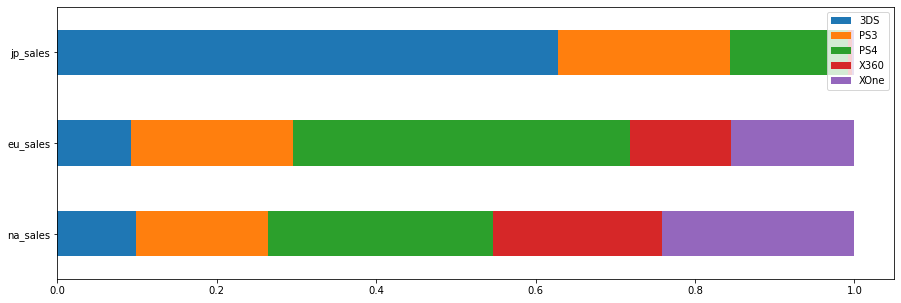

In [78]:
top_pl = df_act.groupby('platform').agg({'total_sales':'sum'}).sort_values(by = 'total_sales',
                                                                    ascending = False).head(5).index
report = df_act.query('platform in @top_pl').groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum()
display(report)

for col in report.columns:
    report[col] =  report[col]/ report[col].sum()   
display(report)    

report.T.plot(kind='barh', stacked=True, figsize=(15,5))
plt.legend(loc='upper right');


В целом, наибольшей популярностью в Японии пользуется плафторма 3DS в противоположность остальным регионам. Мы видим, что распределение игр по платформам в Северной Америке и Европе очень схоже, однако XOne и X360 пользуются большей популярностью в Америке, и не совсем популярны в Японии. Посмотрим на распределение платформ в Японии отдельно.

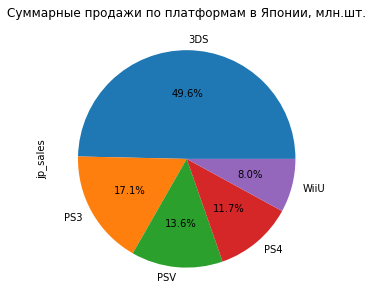

In [79]:
df_act.groupby('platform').agg({'jp_sales':'sum'}).sort_values(by = 'jp_sales', 
                                                                  ascending = False).head(5).plot(kind='pie', rot=70,figsize=(5,5), 
                                                                                          subplots=True, legend=False,  autopct='%1.1f%%');

plt.title('Суммарные продажи по платформам в Японии, млн.шт.');

Как оказалось, вместо XOne и X360 у японцев популярны такие платформы, как PSV и WiiU.

Посмотрим на распределение жанров по регионам.

,na_sales,eu_sales,jp_sales
genre,,,
Action,126.05,118.13,40.49
Others,90.25,88.75,37.23
Role-Playing,46.40,36.97,51.04
Shooter,109.74,87.86,6.61
Sports,65.27,60.52,5.41


,na_sales,eu_sales,jp_sales
genre,,,
Action,0.287976,0.301175,0.287612
Others,0.206187,0.226270,0.264455
Role-Playing,0.106006,0.094256,0.362551
Shooter,0.250714,0.224001,0.046953
Sports,0.149117,0.154297,0.038429


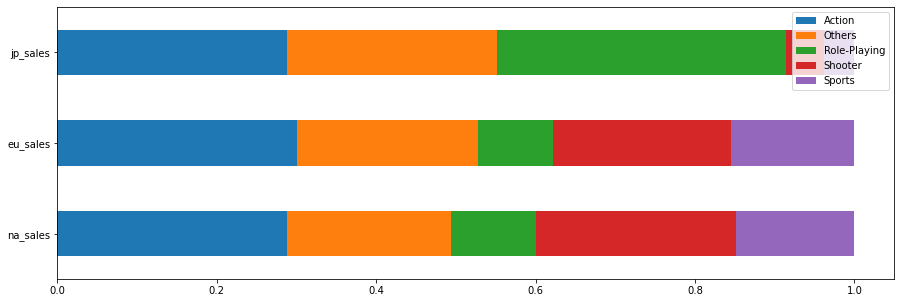

In [80]:
top_gn = df_act.groupby('genre').agg({'total_sales':'sum'}).sort_values(by = 'total_sales',
                                                                    ascending = False).head(5).index
report = df_act.query('genre in @top_gn').groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum()
display(report)

for col in report.columns:
    report[col] =  report[col]/ report[col].sum()   
display(report)    

report.T.plot(kind='barh', stacked=True, figsize=(15,5))
plt.legend(loc='upper right');


По аналогии с анализом платформ, мы видим что и в жанрах японский пользователь отличается от американского или европейского.
Самый популярный жанр для Японии Role-Playing, в то время как в остальных регионах популярен жанр Action. Еще интересно, что жанр Shooter не такой популярный как в Европе и Америке, а жанр Sports совсем не пользуется популярностью в Японии, в то время как занимает значительную долю продаж в остальных регионах.
Очевидно, что какой-то жанр мы упустили из виду при анализе японского пользователя. Взглянем на круговую диаграмму Японии отдельно.

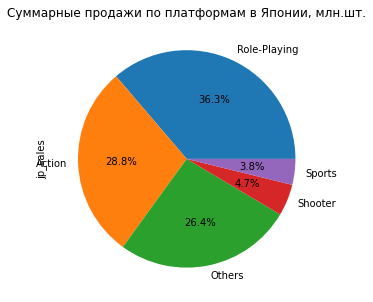

In [81]:
df_act.groupby('genre').agg({'jp_sales':'sum'}).sort_values(by = 'jp_sales', 
                                                                  ascending = False).head(5).plot(kind='pie', rot=70,figsize=(5,5), 
                                                                                          subplots=True, legend=False,  autopct='%1.1f%%');

plt.title('Суммарные продажи по платформам в Японии, млн.шт.');

Как мы видим, вместо жанра Sports у японцев популярен жанр Fighting.

Посмотрим, как влияет возрастной рейтинг на продажи в каждом регионе.

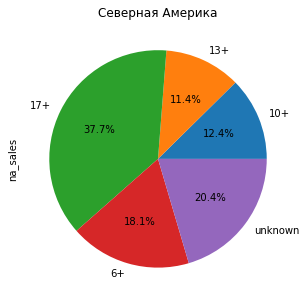

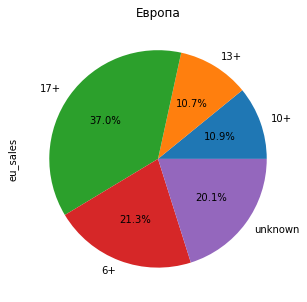

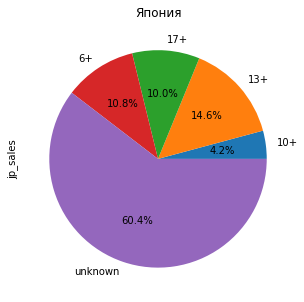

In [82]:
regions = {
    'na_sales': 'Северная Америка',
    'eu_sales': 'Европа',
    'jp_sales': 'Япония'
}    

for title in regions:
    df_act.groupby('rating_desc').agg({title:'sum'}).plot(kind='pie', rot=70,figsize=(5,5),subplots=True, legend=False,
                                                                                         autopct='%1.1f%%');
    plt.title(regions.get(title))
    plt.show()
    
   

Как мы видим из полученных диграмм, наибольшей популярностью в Европе и Америке пользуются игры 17+, в то время как в Японии 60.4% занимают игры с неизвестным рейтингом, скорее всего в Японии есть своя рейтинговая система возрастов.

**Вывод**

Таким образом, мы определили, что часто встречаемый европейский пользователь старше 17 лет играет на платформе PS4 в жанре Action, в то время как американский пользователь играет на платформе PS4 ли XOne в жанрах  Action или Shooter. И совсем не похожий на остальных, японский пользователь неизвестного возраста играет на платформе 3DS в жанре Role-Playing и совсем не увлекается жанром Sports,  в отличии от европейцев и американцев.

## Проверка гипотез и пояснения

На данном этапе наша цель проверить две гипотезы:

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Начнем с первой гипотезы. Установим нулевую гипотезу о равенстве средних двух совокупностей и противопоставим ей альтрнативную гипотезу:

H₀: Средний пользовательский рейтинг платформы Xbox One равен среднему рейтингу платформы PC;\
H₁: Средний пользовательский рейтинг платформы Xbox One не равен среднему рейтингу платформы PC.

Для проверки нулевой и альтернативной гипотезы нам необходимо установить критический уровень и определить равенство дисперсий в двух совокупностях.\
Критические значения задаются выбранным уровнем значимости проверки гипотезы. Уровень значимости — это суммарная вероятность того, что измеренное эмпирически значение окажется далеко от среднего. Предположим, что допустимая вероятность этого - 5%.\
Касательно дисперсий воспользуемся методом `.var`, который поможет нам установить равны дисперсии изучаемых выборок или нет. 

Мы знаем, что в колонках "user_score" есть пропущенные значения. Для проведения t-теста нам необходимо избавиться от пропусков.

In [83]:
#удалим пропуски из столбца "user_score"
df_act = df_act.dropna(subset=['user_score'])

pc_df = df_act[df_act['platform'] == 'PC']
xone_df = df_act[df_act['platform'] == 'XOne']

pc_var = np.var(pc_df['user_score'])
xone_var = np.var(xone_df['user_score'])

if pc_var == xone_var: print('Дисперсии выборок равны.')
else: print('Дисперсии выборок не равны.')   

Дисперсии выборок не равны.


Мы получили всю необходимую информацию и теперь можем провести t-тест. Применим метод scipy.stats.ttest_ind() и передадим ему следующие параметры: массивы, содержащие выборки выручки каждого тарифа отдельно; equal_var=False, т.к. мы установили что дисперсии не равны.

In [84]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(pc_df['user_score'],xone_df['user_score'], equal_var = False)
# equal_var - считать ли равными дисперсии выборок

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.") 

p-значение:  0.14759594013430463
Не получилось отвергнуть нулевую гипотезу.


Благодаря t-тесту мы установили что средний пользовательский рейтинг платформы Xbox One равен среднему рейтингу платформы PC;\.

Далее, установим нулевую и альтернативную гипотезы о равенстве средних пользовательских рейтингов жанров Action и Sports :

H₀: Средний пользовательский рейтинг жанра Action равен среднему рейтингу жанра Sports;\
H₁: Средний пользовательский рейтинг жанра Action не равен среднему рейтингу жанра Sports.

Сначала определим равенство дисперсий, а затем проведем t-тест по аналогии с предыдущей гипотезой.

In [85]:
action_df = df_act[df_act['genre'] == 'Action']
sports_df = df_act[df_act['genre'] == 'Sports']

action_var = np.var(action_df['user_score'])
sports_var = np.var(sports_df['user_score'])

if action_var == sports_var: print('Дисперсии выборок равны.')
else: print('Дисперсии выборок не равны.')   

Дисперсии выборок не равны.


Теперь можем приступать к t-тесту. 

In [86]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(action_df['user_score'],sports_df['user_score'], equal_var = False)
# equal_var - считать ли равными дисперсии выборок

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.") 

p-значение:  1.4460039700704315e-20
Отвергаем нулевую гипотезу.


Таким образом, мы определили, что в среднем пользователи оценивают жанры Action и Sports на разных уровнях. Это соотвествует тому, что мы видели на графиках в предыдущем пункте - жанр Action является самым популярным у пользователей, в то время как Sports находится на 3ем месте по популярности. 

**Вывод**

Мы установили нулевую и альтернативную гипотезы для каждого вопроса и разделили датафрейм на две выборки по каждому вопросу отдельно. Затем чтобы проверить гипотезы о равенстве среднего двух выборок, мы применили метод scipy.stats.ttest_ind().

## Общий вывод

Мы получили данные сервиса интернет-магазина «Стримчик» — архив данных о продажах игр, оценки пользователей и экспертов, жанры и платформы за несколько лет. С помощью предобработки данных мы смогли обработать полученный датасет, рассчитать новые показатели и провести исследовательский анализ данных. Это помогло нам выявить параметры, которые влияют на успешность тех или иных игр.

Мы определили, что несмотряя на существование рынка игр с 1980х годов, пик развития рынка пришел лишь на 2008 год и затем, после 2011 года рынок перешел в стадию стагнации. Это можно объяснить тем, что платформы нашли некий эквилибриум между возможностями рынка и желаниями пользователей. Мы заметили что по мере развития рынка игр, платформы меняли позиции в лидерстве, т.к. ни одна платформа не может существовать более 10 лет в среднем. Причем пика продаж каждая платформа в среднем достигает за 3 года, а затем начинает уступать лидерство на рынке более новой и успешной платформе. Так, мы увидели что за последние несколько лет явное лидерство на рынке принадлежит платформе PS4, однако после 2015 г. наблюдается спад продаж, как и у всего рынка в целом.

В дополнении, мы выявили, что у каждой платформы есть свой топ-селлер, который тянет основную часть продаж и приносит высокий рейтинг платформе. За последние несколько лет данные топ-селлеры имеют жанры Action или Shooter, которые имеют сильную взаимосвязь с оценками пользователей и критиков. При этом, на остальном рынке в целом, ни оценка пользователей, ни оценка критиков практически не влияет на успешность той или иной игры.

Также, мы составили портреты пользователей для каждого региона и заметили, что европейские и американские игроки в целом индентичны, в то время как игроки в Японии имеют свои отичительные черты. Так, в Японии наибольшей популярностью пользуются игры жанра Role-Playing на платформе 3DS. В то же время игроки из Европы и Америки предпочитают игры в жанре Action на платфрме PS4.  

И, в заключении, при помощи статистического анализа мы проверили две гипотезы и установили:

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.